# Intro to Machine Learning with Meteorological Station Data: Part 2

Part 2) __Supervised Learning: Relationship assessment & feature importance.__ <br>
Which variable in the Christman data is the best predictor of rainfall? <br><br>
[Part A) Building a model to predict rainfall likelihood](#Building-a-model-to-predict-rainfall-likelihood) <br>Create a model that best captures the relationship between meteorological variables and rainfall likelihood. <br><br>
[Part B) Using our new model to determine best rainfall predictor](#Feature-Importance) <br> Learn how to utilize scikit-learn's *feature importance* tool as an alternative to linear regression.<br><br>
[Part C) Post-lab Questions](#Questions)<br><br>

__The goals of Part 2 of this Application Lab are to:__<br>
1. Be exposed to a swath of supervised learning algorithms and have some ML algorithm code as a reference for later use.<br>
2. Walk away with some understanding of two uses of supervised learning algorithms: prediction and feature importance.<br>
3. Become familiar with the data processing pipeline required to utilize supervised learning techniques.<br>
4. Learn more vocabulary and building a foundation for future google searches: cross-validation, training v. testing data, metrics (accuracy, recall, precision, f1 score, etc), overfitting/underfitting, balancing datasets, hyperparameters, & feature importance.

__We are using the 2016 Christman dataset once again.__ In fact, much like Part 1 of the application lab, we are building and training models to predict something we already know from the dataset--in this case, if it's raining or not. The point of this application lab is not to conduct cutting-edge research or make novel predictions. Instead, the lab's purpose is to be a learning exercise, so you can walk away with more confidence of how to use ML tools, so that perhaps you can apply them to those more exciting questions.

# Part 0. Read in data into a pandas dataframe.

*This is the same code used in Part 1 of the Application Lab.*

In [2]:
import pandas as pd
import numpy as np
import datetime
import time

Read in the data.

In [3]:
df = pd.read_csv("./christman_2016.csv")
# preview data (also through df.head() & df.tail())
df

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
0,42370,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0
1,42370,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0
2,42370,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0
3,42370,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0
4,42370,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,42735,0.791667,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0.0
8780,42735,0.833333,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0.0
8781,42735,0.875000,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0.0
8782,42735,0.916667,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0.0


### Deal with the time dimension

How many days are in this dataset?

In [4]:
df.day.nunique()

366

__Optional__: transform the day column into a readable date. Can only run once successfully.

In [5]:
df['day'] = [datetime.date.fromordinal(day+693594) for day in df['day']]

---------------------------------------------

# Part 2. Supervised learning

#### We will be using supervised learning methods to perform the following two tasks:
1. Predict the likelihood of rainfall given certain atmospheric conditions
    1. Prepping the data
    2. Building and training models
        1. Logistic regression
        2. Singular vector machines/classifier
        3. Random Forest
        4. Neural Network
2. Determine which variable ("feature") is the best predictor of rainfall, i.e., "feature importance"

---------------------------------------------

# 2.1. Building a model to predict rainfall likelihood

Let's say you want to determine which features or atmospheric variables are the best predictors of rainfall in Christman, CO. <br><br>
Often, one simply regresses some metric of precipitation onto various atmospheric variables, and assume that whatever returns the highest regression coefficient is the best predictor. <br><br>
While linear regression presents a fine first guess, it poses a few problems. Linear regression assumes atmospheric variables are linearly related to precipitation, AND that atmospheric variables are not collinear (both of which are false assumptions). <br><br>
While a linear relationship between predictor & predictand is a good first guess, why limit yourself to linearity when you can just as easily relax that assumption?<br><br>
This is where Machine Learning can come in handy. The rest of this notebook will step through the following Machine Learning model pipeline:<br><br>

![model_pipeline](./model_pipeline.png)

---------------------------------------------

# 2.1.B. Data Preparation

Data preparation is a huge part of building Machine Learning model "pipelines".

There are few steps involved when thinking about building & training a Machine Learning model. Remember, models are "stupid", and there are a few statistical "gotcha's" that may result in your model being biased, inaccurate, or not suitable for the problem at hand. The order of addressing these issues in your data is important!
<br>
1. __What exactly are we trying to predict? A value, an outcome, a category? Define your predictors and predictand.__ This requires revisiting your hypothesis or overarching question. In our case, our predictand is the likelihood of precipitation. We will build a Machine Learning model (actually, a few models) that predicts the likelihood that it's currently precipitating at Christman, CO, given current atmospheric conditions. 
<br><br>
2. __Do you have any missing data? If so, how will you handle them? Keep in mind, decreasing the number of input observations may bias your model.__ In our case, we have no missing data.
<br><br>
3. __Do you have any categorical or non-numeric variables or features? If so, you must figure out how to encode them into numbers.__ For example, you may want to try to label different flavors of El Niño given the oceanic and atmospheric conditions.
<br><br>
4. __How do we ensure that we're training a model that is good at predicting new data?__ Typically, people split their existing data into training, testing, and holdout datasets. This is called performing "__cross-validation__". That is, we will set aside a dataset at the very beginning and call it our "holdout dataset". This dataset is used to evaluate the performance of our final, trained model. The rest of the data is split into "training" and "testing" datasets (called a "__test-train split__"), sometimes iteratively (__"k-folds cross validation"__), and used to train our model. Testing and training datasets are used to optimize model parameters and determine whether the model performance is stable across the entire dataset. *Note:* This could be problematic if there is limited data. Though, if you don't have enough data, you have a bigger problem.
<br><br>
5. __Do your features have the same variance?__ Just like for K-means clustering above, this is an important step to ensuring your model doesn't depend on one variable with large variance too heavily. This step is called "__feature scaling__". Features of the same size also speed up the Gradient Descent algorithm.
<br><br>
6. __If classification is the goal, are there the same number of observations for each feature and outcome? If not, how will you rebalance?__ Luckily, we have the same number of observations (8784) for each feature, but a lack of precipitation is way more common than precipitation. Thus, we will simply oversample the observations associated with precip so that the two outcomes (or "classes") are equal. *Note: It's important that feature scaling or normalization is performed before any rebalancing so that the qualitative statistics (mean, stddev, etc) remain the same.*
<br><br>
7. __What prediction "error" will you try to minimize?__ Most common Machine Learning algorithms operate as optimization problems. They iteratively searche for the best parameters to minimize the error between the predicted value and the actual value. Choosing the appropriate *loss function* is important. For example, absolute error means that small "misses" are equally important compared to large ones. Quadratic error would suggest that large "misses" are more important to minimize. Cubic error would imply that large "misses" are catastrophic.
<br><br>
8. __What are the appropriate validation metrics for assessing your model? Consider the bias-variance trade-off, and whether having false positives or false negatives is more impactful.__ In our case, predicting no rain when there is rain (false negative) is probably more frustrating and potentially more impactful than the other way around (a false positive). 
<br><br>


<br>

### Q1. What exactly are you trying to predict?
First, split data into predictor & predictands. 
I'm going to create (or "engineer") a new feature that indicates whether precipitation occurred. Clearly, this step only needs to be performed once.

In [6]:
df.columns # what is the variable called that indicates precipitation amount?

Index(['day', 'hour', 'temp_F', 'RH', 'dewtemp_F', 'wind_mph', 'wind_dir',
       'windgust', 'windgust_dir', 'pres_Hg', 'SOLIN_Wm2', 'Prec_inches'],
      dtype='object')

In [7]:
df['prec_occur'] = np.array(df.Prec_inches!=0).astype(int)

Then, select the data that will be predictors. 

In [8]:
predictors = df.copy(deep=True) 
# deep = True so that changes to predictors won't be made to df.

# these shouldn't go into predicting whether or not there is rain.
predictors = df.drop(['day','hour','Prec_inches'],axis=1) 
predictors

,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,prec_occur
0,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0
1,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0
2,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0
3,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0
4,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0
...,...,...,...,...,...,...,...,...,...,...
8779,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0
8780,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0
8781,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0
8782,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0


Great, that worked. Now I will assign everything but "prec" to be the predictor array "x", and prec will be the predictand vector "y".

In [9]:
x = predictors.drop('prec_occur',axis=1)
y = predictors.prec_occur

### Q2 & Q3 do not need to be addressed in our dataset.

### Q4. How do we ensure that we're training a model that is good at predicting new data?

Next, perform a test-train split to ensure we can validate our trained model. <br>

This step must be performed before each time the model is trained to ensure we are not baking in any bias among the models we train. That also means the following two steps must also be performed prior to training each model as well. For this reason, I wrote functions to call easily before each model training.

In [10]:
from sklearn.model_selection import train_test_split
from random import randint

In [11]:
def define_holdout_data(x, y, verbose):
    random_state = randint(0,1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
    if verbose==True:
        print("Prior to scaling and rebalacing...")
        print("Shape of training predictors: "+str(np.shape(x_train)))
        print("Shape of testing predictors: "+str(np.shape(x_test)))
        print("Shape of training predictands: "+str(np.shape(y_train)))
        print("Shape of testing predictands: "+str(np.shape(y_test)))
        print(" ")
    return x_train, x_test, y_train, y_test

#### A note on k-folds cross validation

Suppose your training set is slitly different from 

In [12]:
from sklearn.model_selection import StratifiedKFold

### Q5. Do your features have the same variance?

Depending on the ML algorithm,  normalize the features, or perform "__Feature Scaling__", for the same reasons why we normalized prior to running the K-Means clustering algorithm. 
  
The difference here is that I will keep the data as a pandas dataframe rather than converting it to a numpy array beforehand. The "fit_transform" function outputs a numpy array, but we will convert back to a dataframe so that re-balancing the dataset is easier. 
  
*__Note__*: If my predictand wasn't binary, then I would also want to normalize that as well.

In [13]:
from sklearn import preprocessing

In [14]:
def scale_data(x_train, x_test):
    """
    Scale training data so that model reaches optimized weights much faster. 
    
    *All data that enters the model should use the same scaling used to scale the training data.*
    Thus, we also perform scaling on testing data for validation later. 
    Additionally, we return the scaler used to scale any other future input data.
    """
    
    scaler = preprocessing.MinMaxScaler() # normalize 
    x_train_scaled = pd.DataFrame(data=scaler.fit_transform(x_train),index=x_train.index,columns=x_train.columns) 
    x_test_scaled = pd.DataFrame(data=scaler.transform(x_test),index=x_test.index,columns=x_test.columns)
    
    return scaler, x_train_scaled, x_test_scaled

### Q6. Are there the same number of observations for each outcome or class?

Luckily, we have the same number of observations for each feature (8784). But do we have the same number of outcomes for our predictand - i.e., the same number of hours that are precipitating as those that are non-precipitating?

In [15]:
df['prec_occur'].value_counts()

0    8501
1     283
Name: prec_occur, dtype: int64

Definitely not. The outcomes we are trying to predict are extremely unbalanced. Non-precip hours occur 30x more than precip hours. This class imbalance may bias the model because precip hours are underrepresented, which means the model won't have as many instances of precip hours to learn to distinguish precip hours from non-precip hours. 

There are a number of out-of-the-box functions that resample data very precisely. The one I use below simply randomly oversamples the existing precipitating observation data to balance the dataset.

*Note*: This function should be called on both training and testing data separately.

In [16]:
from sklearn.utils import resample

In [17]:
def balance_data(x,y,verbose):
    """Resample data ensure model is not biased towards a particular outcome of precip or no precip."""
    # Combine again to one dataframe to ensure both the predictor and predictand are resampled from the same 
    # observations based on predictand outcomes. 
    dataset = pd.concat([x, y],axis=1)

    # Separating classes
    raining = dataset[dataset['prec_occur'] == 1]
    not_raining = dataset[dataset['prec_occur'] == 0]

    random_state = randint(0,1000)
    oversample = resample(raining, 
                           replace=True, 
                           n_samples=len(not_raining), #set the number of samples to equal the number of the majority class
                           random_state=random_state)

    # Returning to new training set
    oversample_dataset = pd.concat([not_raining, oversample])

    # reseparate oversampled data into X and y sets
    x_bal = oversample_dataset.drop(['prec_occur'], axis=1)
    y_bal = oversample_dataset['prec_occur']

    if verbose==True:
        print("After scaling and rebalacing...")
        print("Shape of predictors: "+str(np.shape(x_bal)))
        print("Shape of predictands: "+str(np.shape(y_bal)))
        print(" ")
    
    return x_bal, y_bal

#### Now, let's put the data prep code from questions 1-6 into a pipeline

In [18]:
def dataprep_pipeline(x, y, verbose):
    # verbose=True prints the shapes of input & output data

    # split into training & testing data
    x_train, x_test, y_train, y_test = define_holdout_data(x, y, verbose) 

    # perform feature scaling
    scaler, x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

    # rebalance according to outcomes (i.e., the number of precipitating 
    # observations & non-precipitating outcomes should be equal)
    if verbose==True:
        print("for training data... ")
    x_train_bal, y_train_bal = balance_data(x_train_scaled, y_train, verbose)
    if verbose==True:
        print("for testing data... ")
    x_test_bal, y_test_bal = balance_data(x_test_scaled, y_test, verbose)
    
    return x_train_bal, y_train_bal, x_test_bal, y_test_bal

### Q7. What are the appropriate metrics for assessing your model?

These metrics will be used to evaluate the model after training. Thus, these functions will also be called for each model.

In [19]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#### First, define functions for evaluating models

I'm simply going to train various models and then look at their model metrics. Then we can make a prediction based on some selected observation to obtain a likelihood that it's raining, and we can compare with our own eyes whether the model gets it right.

Below are some commonly-used metrics for assessing the value of a given Machine Learning model.

"**True Positive (TP)**" Is the number of times the model predicts a positive when the observation is actually positive. In our case, the model predicts that its raining when it is actually raining.<br>
"**False Positive (FP)**" The number of times the model guesses that it's raining when it's not actually raining.<br>
The same applies to **True Negatives (TN)** (correctly predicting that it's not raining) and **False Negatives (FN)** (predicting no rain when it's actually raining).


 - **Precision = TP/(TP + FP)**: The proportion of predicted precipitating events that are actually precipitating.
 - **Accuracy = (TP + TN)/(total)**: The proportion of precipitating hours or non-precipitating hours that are correctly predicted by the model.
 - **Recall = TP/(TP + FN)**: The proportion of precipitating hours that are correctly predicted by the model.<br>
<br>
Other important metrics that we aren't going to look at today:
 - **F1**: a way to capture how well the model predicts the hours that it's actually precipitating.
 - **ROC/AUC**: how well the model separates precipitating hours from non-precipitating hours.

Below, I define a couple of functions that will help us visualize the metrics listed above.

In [20]:
# Print rounded metrics for each model.
def bin_metrics(x, y):
    """Prints accuracy and recall metrics for evaluating 
    classification predictions."""
    
    accuracy = metrics.accuracy_score(x, y)
    recall = metrics.recall_score(x, y)

    print('Accuracy:', round(accuracy, 4))
    print('Recall:', round(recall, 4))
    
    return accuracy, recall


# Pplot confusion matrix
def plot_cm(x, y):
    """Plots the confusion matrix to visualize true 
    & false positives & negatives"""
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.xticks([0.5, 1.5], ['Negatives','Positives'])
    plt.yticks([0.5, 1.5], ['Negatives','Positives'])


Based on our answer to number 7 under the "1. Data Preparation" section above, I will be using **Accuracy** and **Recall** to compare these four different models.

#### Another way we can evaluate the models is to compare precipitation likelihood given the same set of atmospheric conditions.

First, let's choose some observation in the pre-scaled dataset shows that it's raining, and then find the corresponding scaled observation:

In [21]:
def rand_atmos_conditions_precip(index='rand'):
    """
    Function returns atmospheric conditions in a dataframe as well as the scaled
    conditions in a numpy array so that they output a prediction in the model.
    
    If no input is passed, the function will randomly generate an in index to 
    choose from those observations in some training data with precipitation. 
    Otherwise, an integer index between 0 and 200 should be passed.
    """
    # First, perform a test-train split
    x_train, x_test, y_train, _ = define_holdout_data(x, y, verbose=False) 

    # perform feature scaling
    _, x_train_scaled, _ = scale_data(x_train, x_test)

    # this is what will go into the model to output a prediction
    if index=='rand':
        index = randint(0,len(y_train[y_train==1].index)) 
    precipindex = y_train[y_train==1].index.values[index]
    testpredictor = x_train_scaled.loc[precipindex] 
    
    return df.iloc[precipindex], testpredictor    

I will choose some atmospheric conditions after training the first model, and then use those conditions for the other models.

---------------------------------------------

# 2.1.B Train & compare four ML models

Each section below goes through building and training a ML model. In each section, there are a few steps for each model "pipeline":
1. __Randomly perform a test-train split, feature scaling, and resample data to ensure outcomes are balanced__. 
2. __Train your model__.
3. __Assess model metrics with testing and training data__. We begin by first assessing each model's performance by calculating the metrics defined above on the *testing* or *holdout* data; the key here is that the model has never seen this data. <br>__If applicable, tune your model.__ This means choosing new *hyperparameters*, retraining the model, and then reassessing the same model metrics to see if the model yields better results.
3. __Check for model overfitting__. We will also check to see if the model is overfitting by comparing metrics of the testing data to that of the training data. In short, the training data should not be outperforming the testing data.
4. __Actually make a prediction with a single observation__. 

<br><br>

## 2.1.B.a. [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

Let's just start with a simple Logistic Regression. A Logistic Regression is a very specialized model in that in that it only computes the probability of a binary outcome.  
![logistic regression gif](logistic_regression.gif)
<br>
This model also requires that the assumptions of linear regression must hold, i.e., <br>
1. linear relationship between predictors & predictand, 
2. normally distributed residuals between observed predictand and predicted outcome, 
3. no collinearity must exist among predictors, i.e., must be independent<br>

Logistic Regression shouldn't perform any better than a linear regression, so let's just start with this as an illustration of how well linearity assumptions hold in this dataset.<br>

In [22]:
from sklearn.linear_model import LogisticRegression

#### 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.

In [23]:
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=True)

Prior to scaling and rebalacing...
Shape of training predictors: (7027, 9)
Shape of testing predictors: (1757, 9)
Shape of training predictands: (7027,)
Shape of testing predictands: (1757,)
 
for training data... 
After scaling and rebalacing...
Shape of predictors: (13602, 9)
Shape of predictands: (13602,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (3400, 9)
Shape of predictands: (3400,)
 


#### 2. Train the Logistic Regression model

In [24]:
# initialize the model
lr = LogisticRegression(solver='lbfgs') 
# we choose this particular solver because we're not regularizing or penalizing certain features

# fit the model to scaled & balanced training data. Side note: this is where *Gradient Descent* occurs.
lr.fit(x_train_bal, y_train_bal);

#### 3. Assess Logistic Regression's performance using testing data

Now that we've "trained" our model, we make predictions using data that the model has never seen before (i.e., our holdout testing data) to see how it performs. 

Accuracy: 0.8088
Recall: 0.79


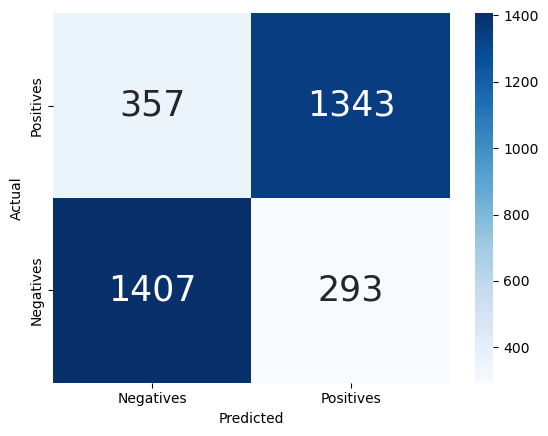

In [25]:
y_pred = lr.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
plot_cm(y_test_bal, y_pred);
lr_acc, lr_rec = bin_metrics(y_test_bal, y_pred)

We determined earlier that False Positives are less harmful than False Negatives. Thus, along with accuracy, which essentially measures how close the model is to the target, we should try to maximize recall. Luckily, recall is the highest-scoring metric for this model (recall = ~87%).<br><br>
Let's focus on accuracy, though, for a moment. Accuracy tells is the percent of correct predictions, whether precipitating or not. The Logistic Regression model, without any additional tuning, can correctly predict whether it's precipitating or not given a set of present atmospheric conditions around 84% of the time. 

#### 4. Check to see if the Logistic Regression model is overfitting (or underfitting)

A very important aspect of tuning machine learning model is to ensure the model isn't overfitting or underfitting.

![overfitting.v.underfitting](underfitting_overfitting.png)

An underfit model is a biased model. Symptoms of underfitting are that your training data performs worse than your testing data, or the model metrics are just poor overall. To alleviate underfitting, introduce more variance into the model by adding more features, use ensemble methods, or increase model complexity. <br><br>
An overfit model means the model is fit very well to the training data, but fails to generalize predictions outside the training dataset. A symptom of overfitting is that the models' training accuracy is much better than the testing accuracy. Overfitting can happen more easily in more complex models, like neural networks. To alleviate overfitting, one needs to reduce variance, through **feature regularization**, lowering model complexity, or performing k-folds cross-validation.<br><br>
Before you dive too deeply into ML and in your own time, I suggest watching [this 6-minute StatQuest YouTube video](https://www.youtube.com/watch?v=EuBBz3bI-aA) to develop an intuition of error, overfitting, and underfitting.

In [26]:
# Compare testing data metrics to data training metrics.
print("Training metrics:")
pred_train= lr.predict(x_train_bal) 
bin_metrics(y_train_bal,pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, y_pred);

Training metrics:
Accuracy: 0.8473
Recall: 0.8725
 
Testing metrics:
Accuracy: 0.8088
Recall: 0.79


Remember:<br>
testing metrics > training metrics = underfitting, model is too simple<br>
testing metrics < training metrics = overfitting, model is too complex<br><br>

#### 5. Make a prediction with the Logistic Regression model

First, we randomly choose some atmospheric conditions using the function defined above. This will be the atmospheric conditions we use for all models we build.

In [27]:
origvals, testpredictor = rand_atmos_conditions_precip()
# print(origvals) # observation from original dataframe
# print(testpredictor) # scaled observation

In [28]:
# prediction output is in the format [probability no rain, probability rain]
lr_prediction = lr.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(lr_prediction, digits=2))

The meteorological conditions are: 
day             2016-05-19
hour                  0.75
temp_F                64.9
RH                    53.9
dewtemp_F             47.8
wind_mph               3.2
wind_dir               224
windgust               8.1
windgust_dir            84
pres_Hg             834.38
SOLIN_Wm2             59.3
Prec_inches           0.02
prec_occur               1
Name: 3354, dtype: object
 
There is a 24.12% chance of precipitation given those meteorological conditions.


<br><br><br>

## 2.1.B.b. [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)
SVMs divide observations into classes based on maximizing the distance between a "kernel" (basically a dividing function) and the elements of each feature/class/variable on a plane.<br>
![SVM image](sphx_glr_plot_iris_svc_0011.png)<br>*A diagram illustrating classification with various SVM kernels using scikit-learn's iris dataset.*

Because the relationships between atmospheric variables and precipitation are inherently non-linear, we will choose a non-linear, "RBF" kernel. 

In [29]:
from sklearn import svm

#### 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.

Repeat a different random train-test split for cross-validation, perform feature scaling, and rebalance each testing & training dataset.

In [30]:
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

#### 2. Train (and tuning) the SVM

#### Choosing hyperparameters

In Machine Learning models, we can choose a few hyperparameters that control the behavior of the model and can improve model performance. In the case of Singular Vector Machines, we can tune "C", the regularization parameter, i.e., how much the weights during training (i.e., Gradient Descent) are penalized if a prediction is incorrect. The lower the C, the higher the penalty. We are unsure what the C value should be. Thus, we train the model three times, each with a different value of C to see what the best value should be.

*__Note: This cell takes about ~1 minute to run__*

In [31]:
acc_scores = []
prec_scores = []
rec_scores = []

C_range = [0.01, 1, 100]
for i in C_range:
    start = time.time()
    print("C is... "+str(i))
    svmclassifier = svm.SVC(C=i, kernel='rbf', gamma='scale', max_iter=20000, probability=True)
    svmclassifier.fit(x_train_bal, y_train_bal)
    
    # Save model metrics in order to choose best hyperparameter
    pred_test= svmclassifier.predict(x_test_bal)
    acc_val = metrics.accuracy_score(y_test_bal, pred_test)
    acc_scores.append(acc_val)
    prec_val = metrics.precision_score(y_test_bal, pred_test)
    prec_scores.append(prec_val)
    rec_val = metrics.recall_score(y_test_bal, pred_test)
    rec_scores.append(rec_val)

    end = time.time()
    print("Took "+str(end-start)+" seconds to train.")

C is... 0.01
Took 24.274803161621094 seconds to train.
C is... 1
Took 11.35015606880188 seconds to train.
C is... 100
Took 11.010765075683594 seconds to train.


/opt/miniconda3/envs/objanalysis_ML/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Max Accuracy (black): 0.8563
Max Precision (red): 0.9137
Max Recall (blue): 0.8877


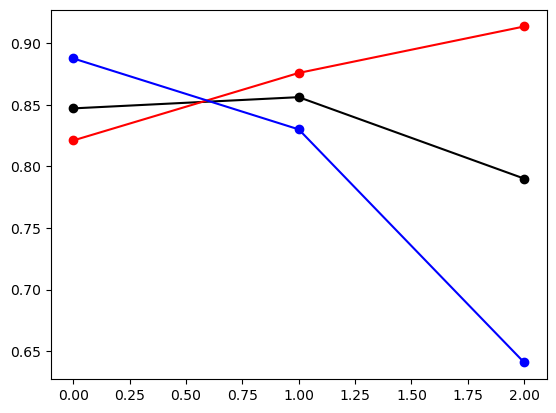

In [32]:
plt.plot(acc_scores, marker='o', color='black')
plt.plot(prec_scores, marker='o', color='red')
plt.plot(rec_scores, marker='o', color='blue')

print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Precision (red):", round(max(prec_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

The SVM with C=1, i.e., a medium weight penalty, results in a balance among accuracy, precision, and recall. We will train our final model with this hyperparameter.

In [33]:
# Define SVM classifier & fit to training data
svmclassifier = svm.SVC(C=1, kernel='rbf', gamma='scale', max_iter=20000, probability=True)
svmclassifier.fit(x_train_bal, y_train_bal);

#### 3. Assess SVM performance using testing data

Again, we throw some data that the model has never seen before to assess how well it performs.

Accuracy: 0.8563
Recall: 0.8301


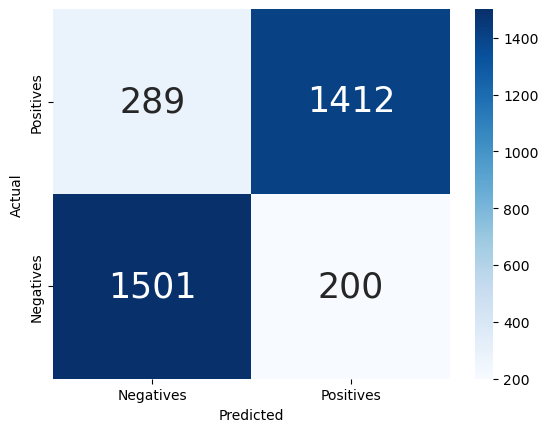

In [34]:
pred_test= svmclassifier.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
svm_acc, svm_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)

In comparing to our last model, using a non-linear Singular Vector Machine instead of a Logistic Regressor increased the recall and accuracy. Looking better... 

#### 4. Check to see if the SVM is overfitting

In [35]:
# Compare testing data metrics to data training metrics.
print("Training metrics:")
svm_pred_train= svmclassifier.predict(x_train_bal) 
bin_metrics(y_train_bal,svm_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.9231
Recall: 0.9535
 
Testing metrics:
Accuracy: 0.8563
Recall: 0.8301


Remember:<br>
testing metrics > training metrics = underfitting, model is too simple<br>
testing metrics < training metrics = overfitting, model is too complex<br>

One can address overfitting in an SVM by changing the kernel to a simpler kernel, or tuning the regularization parameter C. 

#### 5. Make a prediction with the SVM

In [36]:
# prediction output is in the format [probability no rain, probability rain]
svm_prediction = svmclassifier.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(svm_prediction, digits=2))

The meteorological conditions are: 
day             2016-05-19
hour                  0.75
temp_F                64.9
RH                    53.9
dewtemp_F             47.8
wind_mph               3.2
wind_dir               224
windgust               8.1
windgust_dir            84
pres_Hg             834.38
SOLIN_Wm2             59.3
Prec_inches           0.02
prec_occur               1
Name: 3354, dtype: object
 
There is a 4.67% chance of precipitation given those meteorological conditions.


*How does the SVM compare to the linear regression model in terms of assessing precipitation likelihood for the given meteorological observation?*

<br><br><br>

## 2.1.B.c. [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

To understand random forests, one must first understand a [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree). A decision tree is intuitive: it is essentially a flowchart to point to an outcome based on "decisions" for each feature. <br><br>
A Random Forest is an ensemble of decision trees that are randomly constructed based on the features of the dataset and number of decisions. Trees are constructed by randomly choosing a feature to "seed" each tree, and then making rules or associations with other features to lead to the specified outcome.

![random_forest](Random_forest_diagram_complete.png)

In [37]:
from sklearn.ensemble import RandomForestClassifier

#### 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.

Perform a train-test split for cross-validation, perform feature scaling, and rebalance each testing & training dataset.

In [38]:
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

#### 2. Train (and tuning) the Random Forest model

#### Choosing hyperparameters

There are many hyperparameters one can decide upon when tuning the Random Forest classifier. The two we will be adjusting is 
1. The number of estimators or "trees" in the forest
2. The depth of the tree, or how many "decisions" are made until convergence is reached. 

In [39]:
acc_scores = []
rec_scores = []

num_est = [10, 50, 500] # number of trees
depth = [2, 10, 100] # number of decisions
for i in num_est:
    start = time.time()
    print("Number of estimators is "+str(i))

    for k in depth:
        print("depth is "+str(k))
        forest = RandomForestClassifier(n_estimators=i, max_depth=k)
        forest.fit(x_train_bal, y_train_bal)
        
        # cross validate & evaluate metrics based on testing data
        pred_test= forest.predict(x_test_bal)
        acc_val = metrics.accuracy_score(y_test_bal, pred_test)
        acc_scores.append(acc_val)
        rec_val = metrics.recall_score(y_test_bal, pred_test)
        rec_scores.append(rec_val)

    end = time.time()
    print("Random Forest took "+str(end-start)+" seconds.")

Number of estimators is 10
depth is 2
depth is 10
depth is 100
Random Forest took 0.36768174171447754 seconds.
Number of estimators is 50
depth is 2
depth is 10
depth is 100
Random Forest took 1.4868648052215576 seconds.
Number of estimators is 500
depth is 2
depth is 10
depth is 100
Random Forest took 15.69469690322876 seconds.


Max Accuracy (black): 0.82
Max Recall (blue): 0.7352


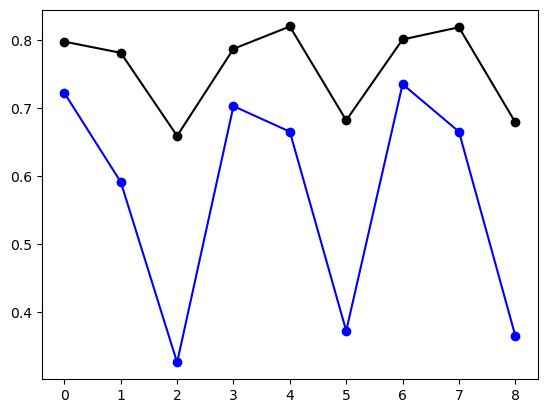

In [40]:
plt.plot(acc_scores, marker='o', color='black')
plt.plot(rec_scores, marker='o', color='blue')
print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

**x =** <br>
0, 1, 2: number of estimators = 10<br>
3, 4, 5: number of estimators = 50<br>
6, 7, 8: number of estimators = 500<br>
<br>
0, 3, 6: depth range = 2<br>
1, 4, 7: depth range = 10<br>
2, 5, 8: depth range = 100<br>

Choosing the right hyperparameters for this model requires revisiting which metrics are most important to our question. We decided early that we care the most about maximizing recall (blue) and accuracy (black). <br><br>
This leads us choosing the parameters at either x=3, where the number of estimators is 50 and the depth range is 2, or x=6, where the number of estimators is 500 and the depth range is 2. Since computational time increases dramatically with number of estimators, let's choose the hyperparameters associated with x=3.

In [41]:
forest = RandomForestClassifier(n_estimators=10, max_depth=2);
forest.fit(x_train_bal, y_train_bal);

#### 3. Assess the Random Forest's performance using testing data

Once again, we will use our testing data to make an initial evaluation of how the model is doing.

Accuracy: 0.803
Recall: 0.7446


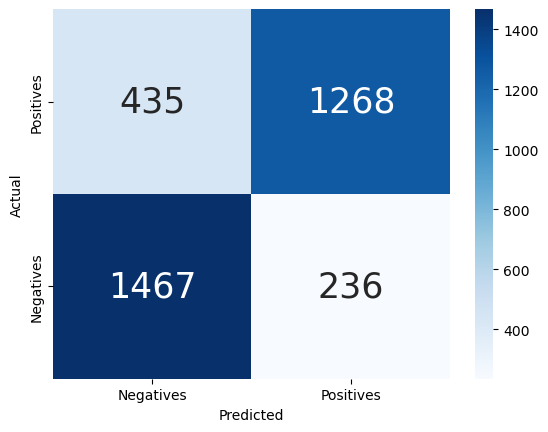

In [42]:
pred_test= forest.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
forest_acc, forest_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)

#### 4. Check to see if the Random Forest is overfitting

In [43]:
# Compare testing data metrics to data training metrics.
print("Training metrics:")
rf_pred_train= forest.predict(x_train_bal) 
bin_metrics(y_train_bal,rf_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.8348
Recall: 0.8089
 
Testing metrics:
Accuracy: 0.803
Recall: 0.7446


Remember:<br>
testing metrics > training metrics = underfitting, model is too simple<br>
testing metrics < training metrics = overfitting, model is too complex

Random forests seldom overfit, but if they do, one should try increasing the number of trees, or decreasing the amount of data used to construct each tree. See scikit-learn's [Random Forest Classifier webpage](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for information on more hyperparameters one can tune to address overfitting.

#### 5. Make a prediction with the Random Forest

In [44]:
# prediction output is in the format [probability no rain, probability rain]
forest_prediction = forest.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(forest_prediction, digits=2))

The meteorological conditions are: 
day             2016-05-19
hour                  0.75
temp_F                64.9
RH                    53.9
dewtemp_F             47.8
wind_mph               3.2
wind_dir               224
windgust               8.1
windgust_dir            84
pres_Hg             834.38
SOLIN_Wm2             59.3
Prec_inches           0.02
prec_occur               1
Name: 3354, dtype: object
 
There is a 29.47% chance of precipitation given those meteorological conditions.


*The random forest yields yet another percent chance of precipitation given the meteorological conditions... hmm...*

<br><br><br>

## 2.1.B.d. [Neural Network](https://blog.insightdatascience.com/a-quick-introduction-to-vanilla-neural-networks-b0998c6216a1)
![neural net chart](neural_net.gif)<br>
![neural net equation](neural_net_equation.gif)

*Note: there is a TON of information online about Neural Networks.* I suggest starting with the 3-part blog series on neural networks accessible in the link above for a gentle introduction to the theory. <br><br>
If you'd rather absorb new information through watching a video, I found [this three-part series of youtube videos](https://www.youtube.com/watch?v=aircAruvnKk) (totaling about an hour in length) to be very helpful.<br><br>
Another great resource is [machinelearningmastery.com](machinelearningmastery.com). In fact, the model below is based off of [this blog post](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/). 

In [45]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#### 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.

Split test & training data, perform feature scaling, and rebalance dataset according to outcomes.

In [46]:
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

#### 2. Train (and build and compile) the Neural Network

There are lots of hyperparameters here. Please read the comments to guide you in playing with them later!

#### Build a very simple Neural Network & compile

In [47]:
number_inputs = len(x_train_bal.columns)

# create model
nn = Sequential()
nn.add(Dense(number_inputs, input_dim=number_inputs, activation='relu'))

# Try uncommenting this to address overfitting
# from keras.regularizers import l2
# reg = l2(0.001)
# nn.add(Dense(number_inputs, activation='relu',bias_regularizer=reg,activity_regularizer=reg))

# try commenting out one and then the other
nn.add(Dense(1, activation='sigmoid'))
#nn.addDense(1, activation='softmax'))

# Compile model 
# Also try changing the learning rate.
learning_rate = 0.001 # only used in the SGD optimizer.

# Also try commenting out one & then the other. 
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
#nn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=['accuracy']) 

2024-04-10 15:50:53.835858: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 15:50:53.866877: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f88977476b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-10 15:50:53.866894: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


#### Actually training the model.

In [48]:
batch_size = 24 # The number of samples the network sees before it backpropagates (batch size) # 24 & 32 yield accuracy = 87%
epochs = 100 # The number of times the network will loop through the entire dataset (epochs)
shuffle = True # Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 # Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

# Train the neural network!
start = time.time()

history = nn.fit(x_train_bal, y_train_bal, validation_data=(x_test_bal, y_test_bal), 
          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose)

end = time.time()
print("Neural Network took "+str(end-start)+" seconds to train.")

Epoch 1/100
567/567 - 0s - loss: 0.6554 - accuracy: 0.6564 - val_loss: 0.5986 - val_accuracy: 0.7074
Epoch 2/100
567/567 - 0s - loss: 0.5419 - accuracy: 0.7708 - val_loss: 0.4950 - val_accuracy: 0.7791
Epoch 3/100
567/567 - 0s - loss: 0.4717 - accuracy: 0.7981 - val_loss: 0.4431 - val_accuracy: 0.7941
Epoch 4/100
567/567 - 0s - loss: 0.4374 - accuracy: 0.8080 - val_loss: 0.4120 - val_accuracy: 0.8206
Epoch 5/100
567/567 - 0s - loss: 0.4155 - accuracy: 0.8233 - val_loss: 0.3929 - val_accuracy: 0.8338
Epoch 6/100
567/567 - 0s - loss: 0.3996 - accuracy: 0.8295 - val_loss: 0.3764 - val_accuracy: 0.8291
Epoch 7/100
567/567 - 0s - loss: 0.3864 - accuracy: 0.8350 - val_loss: 0.3636 - val_accuracy: 0.8515
Epoch 8/100
567/567 - 0s - loss: 0.3764 - accuracy: 0.8378 - val_loss: 0.3527 - val_accuracy: 0.8529
Epoch 9/100
567/567 - 0s - loss: 0.3681 - accuracy: 0.8413 - val_loss: 0.3442 - val_accuracy: 0.8500
Epoch 10/100
567/567 - 0s - loss: 0.3625 - accuracy: 0.8436 - val_loss: 0.3393 - val_accura

#### Accuracy & loss with epochs
Neural networks train in __epochs__. During each epoch, the model trains by sweeping over each layer, adjusting weights based on their resulting errors, through processes called __forward propagation__ and __backpropagation__. By plotting the model accuracy & loss which each epoch, we can visualize how the model error evolves with training.

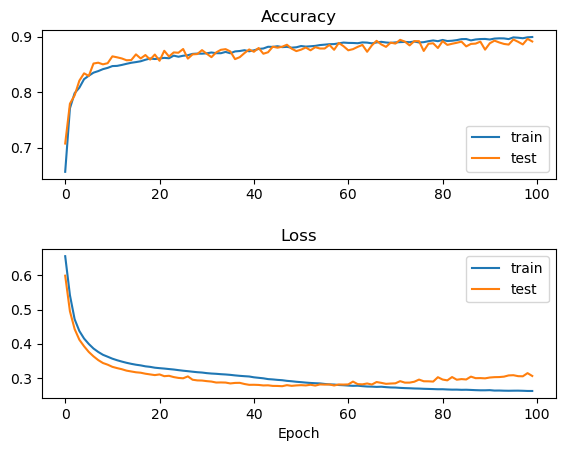

In [49]:
figure, axes = plt.subplots(nrows=2,ncols=1)
figure.tight_layout(pad=3.0)

# plot accuracy during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend();

# plot loss during training
plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch");
plt.legend()
plt.show();

#### 3. Assess Neural Network's performance using testing data

Though the accuracy is pictured above, additionally quantify recall on testing data with the same functions used previously to remain consistent

Accuracy: 0.8912
Recall: 0.8882


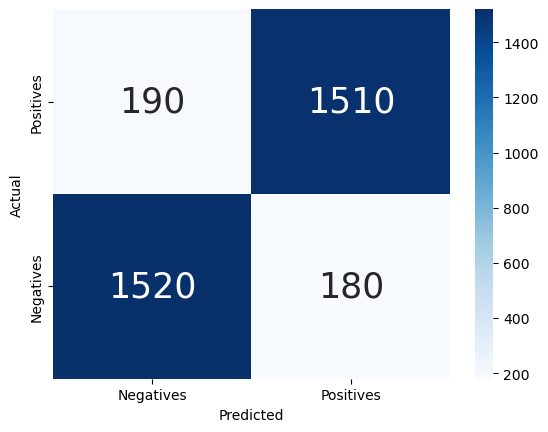

In [50]:
pred_test= (nn.predict(x_test_bal)>0.5).astype("int32")
nn_acc, nn_rec = bin_metrics(y_test_bal, pred_test)
plot_cm(y_test_bal, pred_test)

#### 4. Check to see if the Neural Network is overfitting

In [51]:
# Compare testing data metrics to data training metrics.
print("Training metrics:")
nn_pred_train= (nn.predict(x_train_bal)>0.5).astype("int32")
bin_metrics(y_train_bal,nn_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.8987
Recall: 0.9165
 
Testing metrics:
Accuracy: 0.8912
Recall: 0.8882


Neural networks can easily overfit because they are very complex and can fit to the training data extremely well,  which prevents them from generalizing to other data (like the testing data). 

#### 5. Make a prediction with the Neural Network

In [52]:
# prediction output is in the format [probability no rain, probability rain]
nn_prediction = nn.predict(np.array(testpredictor).reshape(1, -1))[0][0]*100
print("The meteorological conditions are: ")
print(origvals)
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(nn_prediction, digits=2))

The meteorological conditions are: 
day             2016-05-19
hour                  0.75
temp_F                64.9
RH                    53.9
dewtemp_F             47.8
wind_mph               3.2
wind_dir               224
windgust               8.1
windgust_dir            84
pres_Hg             834.38
SOLIN_Wm2             59.3
Prec_inches           0.02
prec_occur               1
Name: 3354, dtype: object
There is a 11.51% chance of precipitation given those meteorological conditions.


*Interesting... How does the Neural Network's estimate of %chance precip compare to that of the other models? See below for final intermodel comparison.*

<br><br>

---------------------------------------------

# Final intermodel comparison

In [53]:
model_metrics = pd.DataFrame({'Metrics':['Accuracy','Recall','Prediction example'],
     'Logistic Regression':[lr_acc, lr_rec, lr_prediction],
    'Singular Vector Machine':[svm_acc, svm_rec, svm_prediction],
    'Random Forest':[forest_acc, forest_rec, forest_prediction],
    'Neural Network':[nn_acc, nn_rec, nn_prediction]})
model_metrics = model_metrics.set_index('Metrics')
model_metrics

,Logistic Regression,Singular Vector Machine,Random Forest,Neural Network
Metrics,,,,
Accuracy,0.808824,0.856261,0.802995,0.891176
Recall,0.790000,0.830100,0.744568,0.888235
Prediction example,24.122552,4.667181,29.466904,11.511269


<br><br>

---------------------------------------------

# Feature Importance

The code below shows the way one would identify the most important features in each model, i.e., the best predictors of rainfall. The code looks a little different from model to model.

In [54]:
# If you want to look at the pre-scaled data used in the models
#balanceddf
#balanceddf.drop(columns=['prec_occur'])

#### Feature Importance in Logistic Regression:

In [55]:
pd.DataFrame(abs(lr.coef_[0]),
             index = x.columns,
             columns=['importance']).sort_values('importance',ascending=False)

,importance
RH,9.817336
windgust,8.616871
temp_F,2.926319
SOLIN_Wm2,1.893801
pres_Hg,1.152647
wind_mph,0.831553
dewtemp_F,0.674285
wind_dir,0.263946
windgust_dir,0.112973


#### SVM feature importance

**Feature Importance is not possible with non-linear Singular Vector Machines** because the data is transformed by the kernel into another space that is unrelated to the input space.

#### Finding most important features in a Random Forest model

In [56]:
pd.DataFrame(forest.feature_importances_,
                                   index = x.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

,importance
RH,0.389670
dewtemp_F,0.199950
temp_F,0.182814
wind_mph,0.111017
windgust,0.060078
SOLIN_Wm2,0.047196
wind_dir,0.009275
windgust_dir,0.000000
pres_Hg,0.000000


#### Neural Network feature importance

In [57]:
cols = x.columns.values
nn_featimportance = []
for var in cols:
    # create a vector corresponding to a 1 where the feature is located:
    inputvector = np.array((cols==var).astype(int).reshape(1, -1))
    nn_featimportance.append(nn.predict(inputvector)[0][0]*100)

In [58]:
pd.DataFrame( nn_featimportance,
             index = x.columns,
             columns=['importance']).sort_values('importance',ascending=False)

,importance
SOLIN_Wm2,9.999891e+01
RH,9.996130e+01
windgust,3.321767e-02
dewtemp_F,1.000450e-03
wind_dir,1.553072e-04
windgust_dir,8.484776e-05
temp_F,6.227345e-07
pres_Hg,5.887066e-07
wind_mph,5.174594e-09


<br><br><br>

---------------------------------------------

# Questions

In [59]:
from solutions import supervised

1. __Why do you think the order of the data preparation is important, i.e., one should perform the train-test split before feature scaling and rebalancing? *Hint: think about using this model for future predictions.*__

In [60]:
supervised.answer1()

Let's say you perform feature scaling before the train-test split. This means the scaling of the unseen data (the testing data) *depends on* the training data. So imagine you are provided the *trained* model from an external source. You'd like to use the model to determine if some meteorological conditions in August are going to produce rain. Nor you or the model knows how to scale the data in such a way that the model can make an educated guess. Thus, the model sees these data as those with seemingly outlandish values. The importance of the order of data preparation is why building *__data preparation pipelines__* is so important in using Machine Learning.

2. __Why did we choose to use accuracy, recall, and predicted precipitation probability as a way to compare models?__

In [61]:
supervised.answer2()

No one likes an incorrect weather forecast, but people are probably more upset when the forecast calls for a sunny day and it ends up raining. In our case, that means the model would be predicting no precipitation when there actually is precipitation - a false negative. Revisit the equations for accuracy & recall in section 2.1.B, Q7 above. Accuracy and recall contain the number of false negatives in the denominator. Thus, maximizing these metrics require minimizing the number of false negatives. <br><br>Predicted precipitation probability provides a sanity test for us to make sure the model isn't way off base. It allows us to see for ourselves: given X meteorological conditions and our own understanding of meteorology, would rain seem likely? Is the model actually doing something realistic?

3. __Now that you have some exposure to various models, what do you think might be some pros and cons regarding each model?__

In [62]:
supervised.answer3()

<br>1. __Logistic regression__ tends to overgeneralize or underfit data, but is easy to implement, to understand and easy to back out feature importance.<br>2. __Singular Vector Machines__ are great at capturing complex relationships, but cannot back out feature importance. Plus, the use of the kernel makes them hard to interpret.<br>3. __Random forests__ are easier to understand, generally do not overfit, and can capture complex relationships, and can provide feature importance, but they can be slow to train and there are a lot of hyperparameters to choose from.<br>4. __Neural Networks__ are great at capturing complex relationships. But they are slow to train and are susceptible to overfitting.

4. __Collinearity, or non-zero correlation among features, results in a model that is overly complex, reduces the statistical significance of the fit of the model, and prevents one from correctly identifying the importance of features. Are there features included in these models that are collinear? You may assess this by running the code below. If so, how do you think we should address collinearity?__

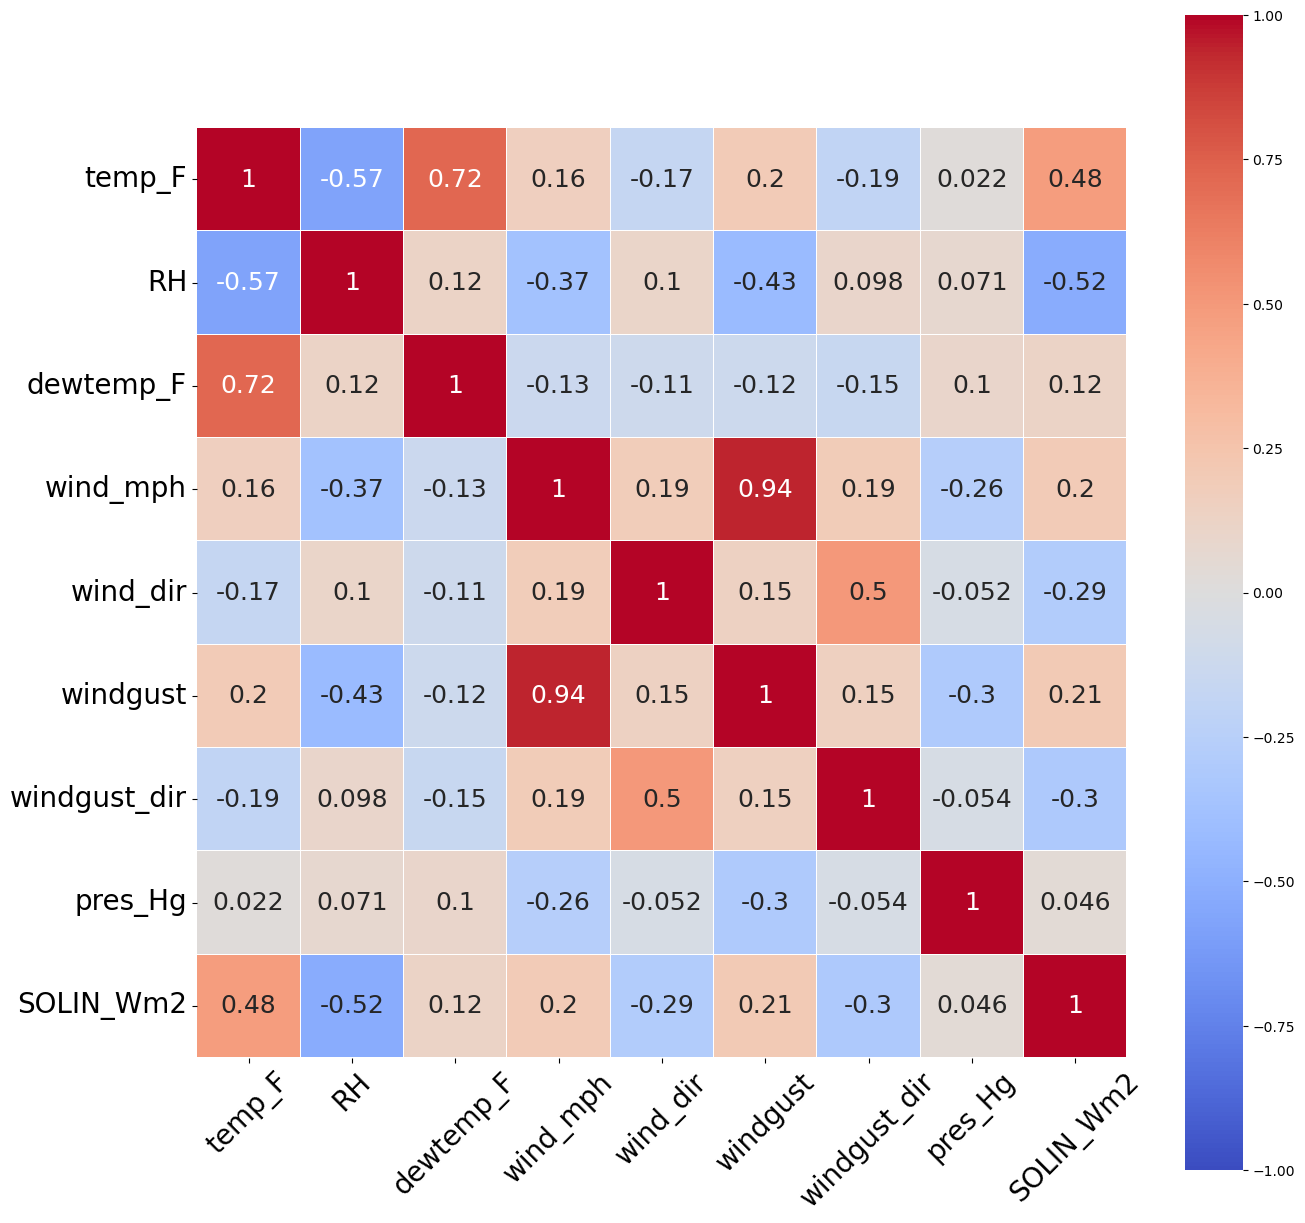

In [63]:
plt.figure(figsize=[15, 15])
ax = sns.heatmap(x.corr(), cmap='coolwarm', annot=True, linewidths=0.2, square=True, vmin=-1, vmax=1,annot_kws={"size": 18});
plt.xticks(fontsize=20,rotation=45);
plt.yticks(fontsize=20,rotation=0);

In [64]:
supervised.answer4()

First, we should assess which features are collinear. If we don't have that many features, we could use our meteorological expertise to simply remove one of the features that shares collinearity with other features. Another way to address collinearity is to use **feature regularization**, or add weights that penalize features that add noise, ultimately reducing model complexity.<br><br>Below, I try re-training the Random Forest model after removing wind_mph, wind_dir, dewtemp_F, windgust_dir, and SOLIN_Wm2.<br><br>

'Uncomment & run %load collinearity_solution.py below'

In [65]:
# %load collinearity_solution.py

5. __For fun: try playing around with the neural network to see what happens. You can change the optimizer, the batch size, the number of epochs, the activation function of the last layer, and the learning rate.__